In [41]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('Student_performance_data .csv')
df.info()
df.describe()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB
   StudentID  Age  Gende

In [24]:
# StudentID is meaningless, as it's an arbitrary identifier

# Remove all redundant/irrelevant columns
df.drop('StudentID', axis=1, inplace=True)

In [25]:
def AllVsTarget(df, targetName):
    fig, axs = plt.subplots(len(df.columns) // 2, 2, figsize=(12,10))
    i = 0
    for col in df.columns:
        if col == targetName:
            continue
        a = i // 2
        b = i % 2
        i = i + 1
        axs[a, b].scatter(df[col], df[targetName], alpha=0.2)
        axs[a, b].set_title('{} vs {}'.format(col, targetName))
        axs[a, b].set_xlabel(col)
        axs[a, b].set_ylabel(targetName)
    plt.tight_layout()
    plt.show()


def Dists(df, bins=50):
    fig, axs = plt.subplots((len(df.columns) + 1) // 2, 2, figsize=(12,10))
    i = 0
    for col in df.columns:
        a = i // 2
        b = i % 2
        i = i + 1
        axs[a, b].hist(df[col], bins=bins, color='skyblue', edgecolor='black')
        axs[a, b].set_title('{} distribution'.format(col))
        axs[a, b].set_xlabel(col)
        axs[a, b].set_ylabel("Frequency")
        axs[a, b].grid(True)
    plt.tight_layout()
    plt.show()

# Univariate analysis

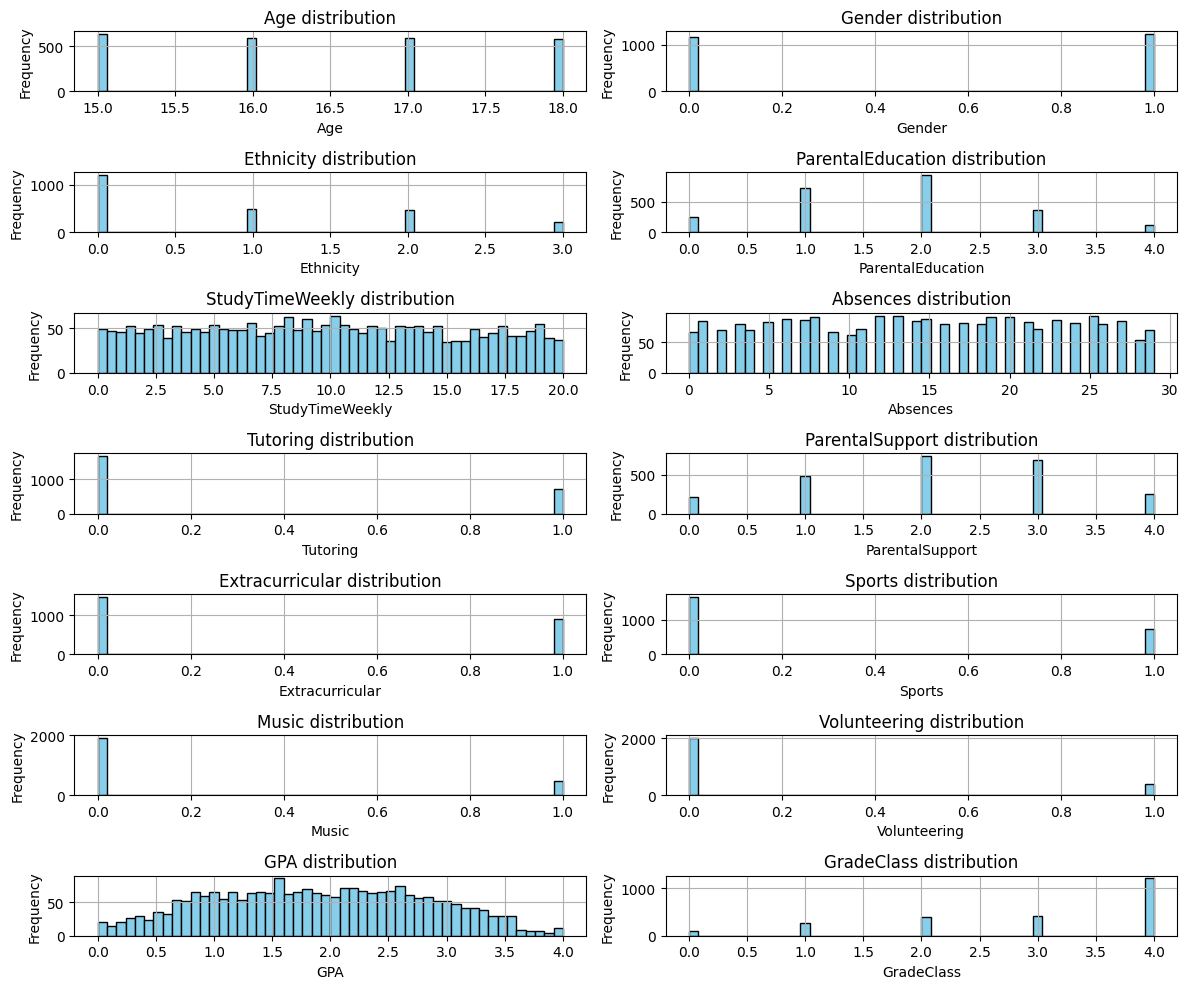

In [26]:
Dists(df)

# Bivariate analysis
As GPA and GradeClass represent the same thing, we should observe the features' relationships with both of them.
## All variables vs GPA

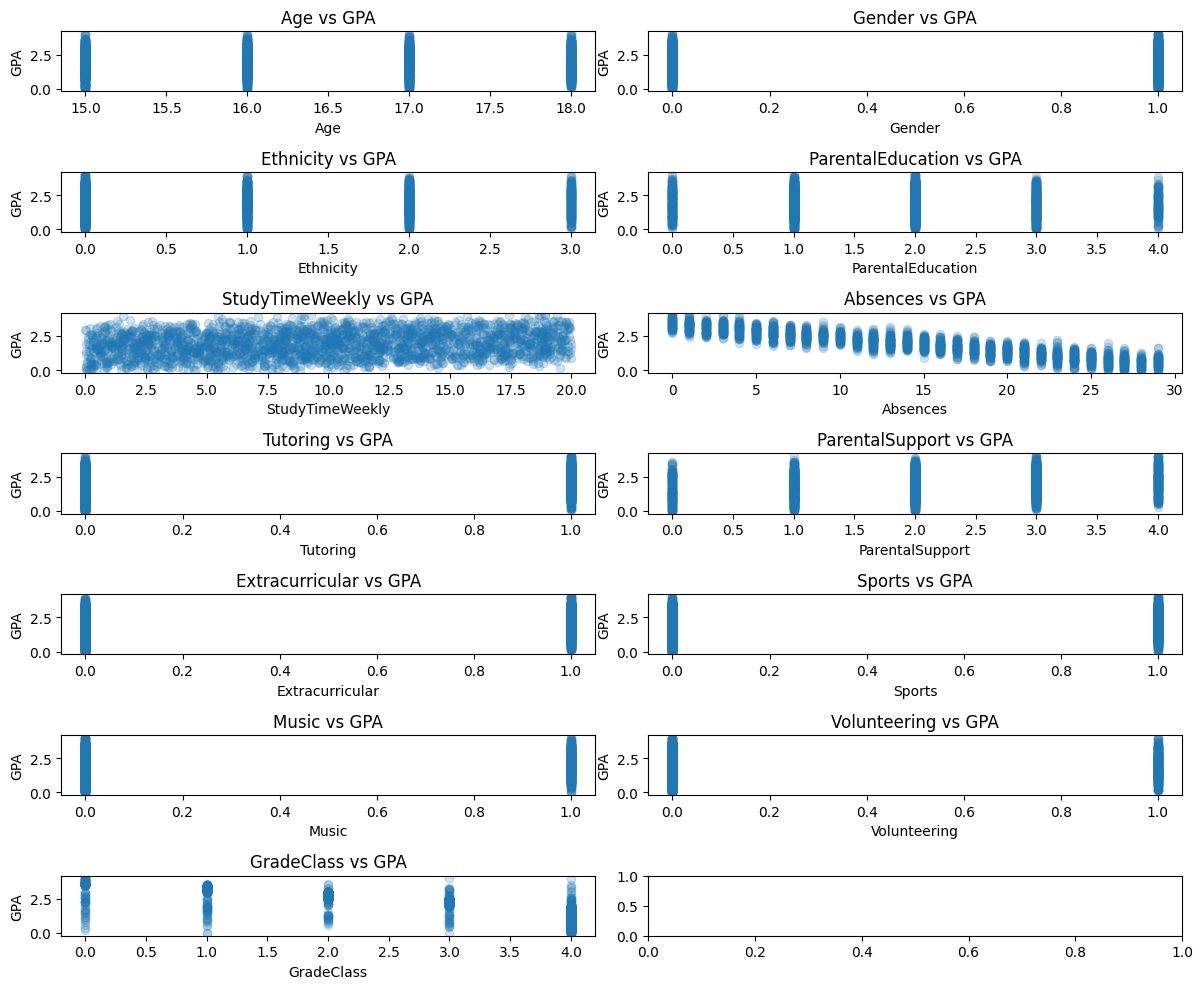

In [27]:
AllVsTarget(df, 'GPA')

## All variables vs GradeClass

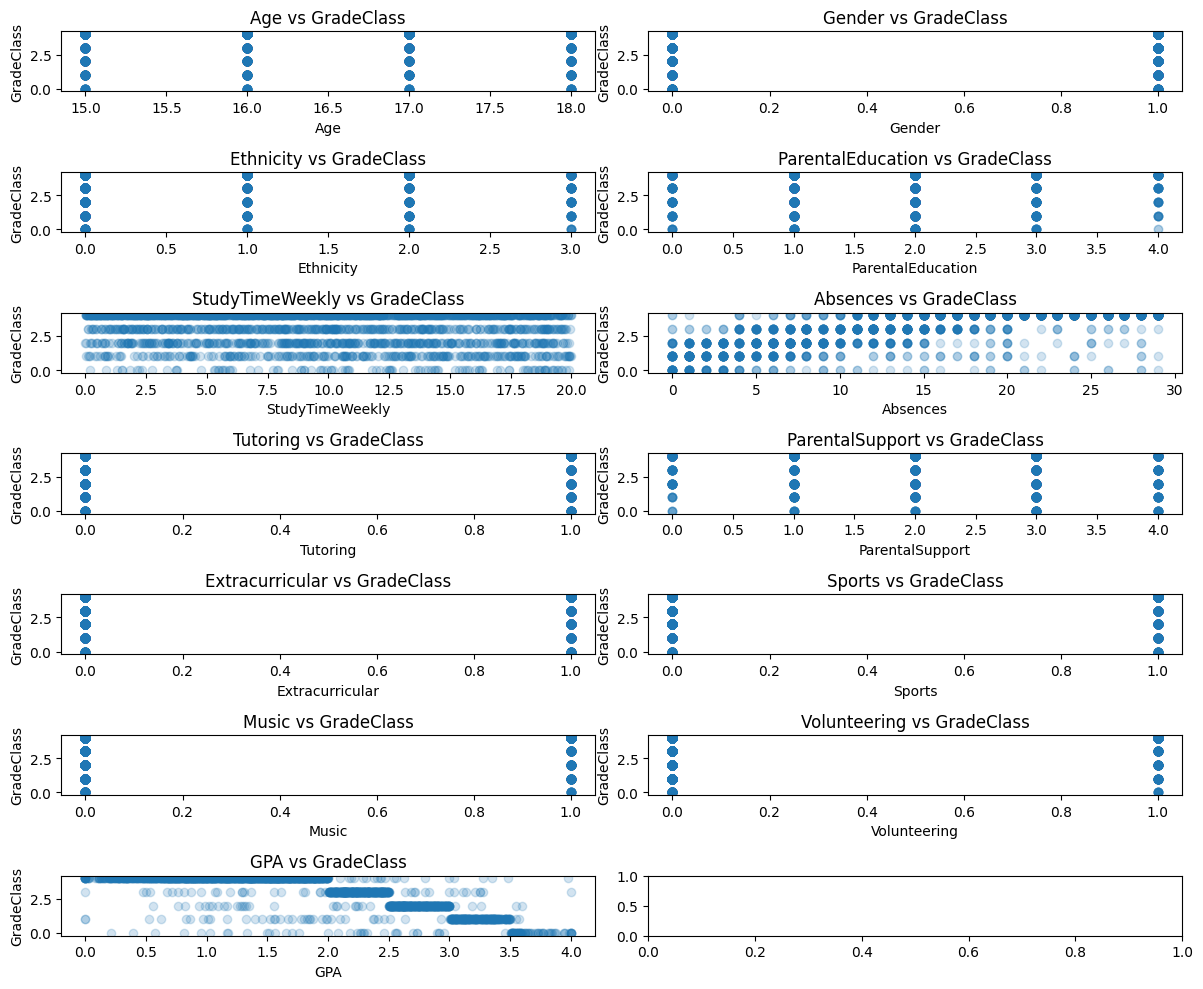

In [28]:
AllVsTarget(df, 'GradeClass')

# Observation notes:
1. Only StudyTimeWeekly and Absences exhibit clear correlation to target variables.
2. `GradeClass`'s relationship with all the other variables is very murky, and, especially concerning GPA, it shouldn't be so noisy. Thus, we will recalculate it from GPA.

In [29]:
# Recalculate GradeClass from GPA
def GradeClass(GPA):
    if GPA < 2:
        # < 2 implies F grade (which is 4)
        return 4
    elif GPA < 2.5:
        # 2 <= x < 2.5 implies D grade (which is 3)
        return 3
    elif GPA < 3:
        # 2.5 <= x < 3 implies C grade (which is 2)
        return 2
    elif GPA < 3.5:
        # 3 <= x < 3.5 implies B grade (which is 1)
        return 1
    else:
        # 3.5 <= x implies A grade (which is 0)
        return 0


df['GradeClass'] = [GradeClass(x) for x in df['GPA']]

## Re-plot after recalculation:

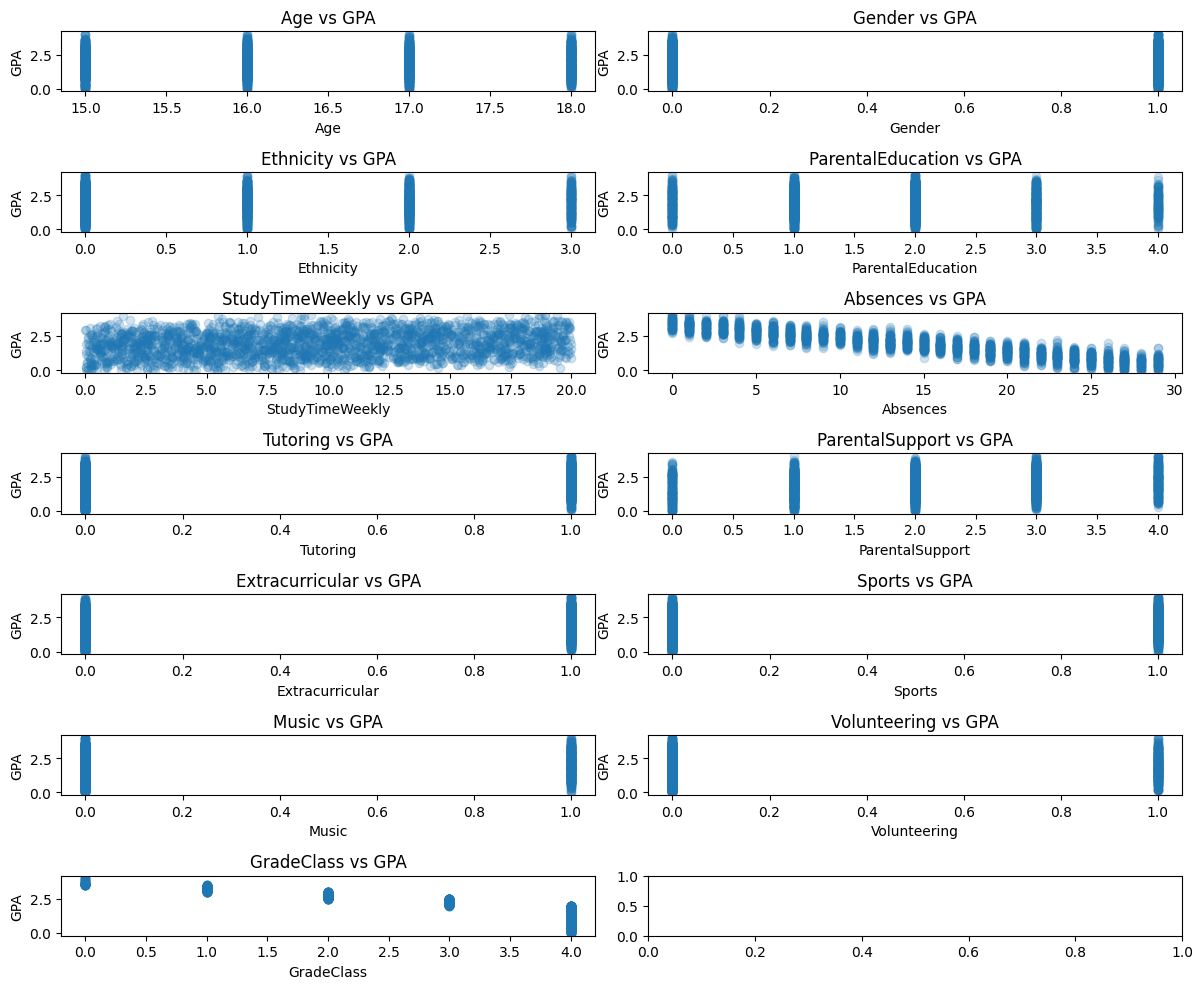

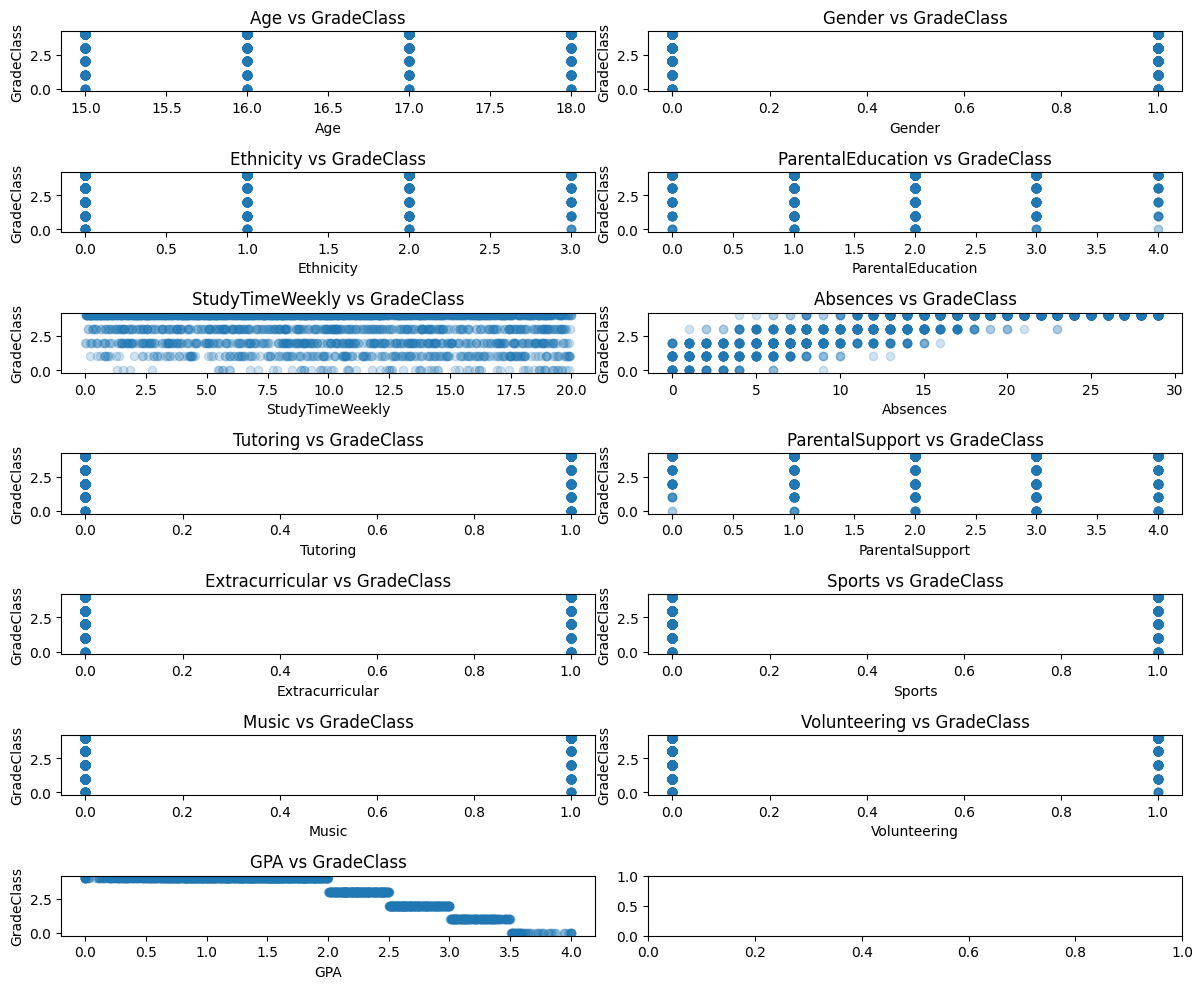

In [30]:
AllVsTarget(df, 'GPA')
AllVsTarget(df, 'GradeClass')

# Modelling

## Segregate input vectors and targets

In [31]:
# Prepare inputs and targets
X = df.drop(['GPA', 'GradeClass'], axis=1)
Y = df['GradeClass']

## Pre-process (just split up for now)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Train-test split
split_random_state = 101
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=split_random_state)

## Baseline machine learning classification algorithms

In [33]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)

y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg, target_names=['A', 'B', 'C', 'D', 'F']))


from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=23)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=['A', 'B', 'C', 'D', 'F']))

import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="multi:softmax", num_class=5, eval_metric="mlogloss")
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb, target_names=['A', 'B', 'C', 'D', 'F']))

Logistic Regression:
              precision    recall  f1-score   support

           A       0.50      0.33      0.40        15
           B       0.60      0.63      0.62        51
           C       0.68      0.67      0.68        73
           D       0.70      0.74      0.72        87
           F       0.94      0.94      0.94       253

    accuracy                           0.81       479
   macro avg       0.68      0.66      0.67       479
weighted avg       0.81      0.81      0.81       479

Random Forest:
              precision    recall  f1-score   support

           A       0.67      0.13      0.22        15
           B       0.58      0.61      0.60        51
           C       0.56      0.67      0.61        73
           D       0.60      0.52      0.56        87
           F       0.91      0.94      0.92       253

    accuracy                           0.76       479
   macro avg       0.66      0.57      0.58       479
weighted avg       0.76      0.76      0.

## Deep learning algorithm: TensorFlow

In [34]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Input(shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(5, activation='softmax')  # softmax for multi-class
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=1)

y_pred_dl = model.predict(X_test)
y_pred_dl_classes = y_pred_dl.argmax(axis=1)

print("Deep Learning Model:")
print(classification_report(y_test, y_pred_dl_classes, target_names=['A', 'B', 'C', 'D', 'F']))

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4329 - loss: 1.3431 - val_accuracy: 0.6719 - val_loss: 0.6749
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6985 - loss: 0.6748 - val_accuracy: 0.7448 - val_loss: 0.5701
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7365 - loss: 0.5743 - val_accuracy: 0.7604 - val_loss: 0.5323
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7528 - loss: 0.5395 - val_accuracy: 0.7760 - val_loss: 0.4770
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7747 - loss: 0.5106 - val_accuracy: 0.7500 - val_loss: 0.4609
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7791 - loss: 0.4870 - val_accuracy: 0.7917 - val_loss: 0.4535
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7981 - loss: 0.4604 - val_accuracy: 0.7969 - val_loss: 0.4353
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7894 - loss: 0.4565 - val_accuracy: 0.8125 - val_loss:

# Performance observations:
1. Models tend to perform better for A and F cases.
2. Ensemble models tend to perform the best for this use case, and deep learning even better.
3. Test accuracy scores can vary wildly for different train-test splits (experiment by changing `split_random_state` in the split code above)

# Considerations:
Inconsistencies are mostly caused by the vagueness of a letter score. An F encompasses nearly half the normal distribution of GPA scores.

**To combat this, consider fitting a regression model to GPA instead**: *GradeClass* can then be calculated from **simple if statements**. This could result in **increased model understanding** due to more visible information. The following code demonstrates using such a model to classify a list of input vectors:

In [35]:
def RegPredict(model, x):
    return [GradeClass(pred) for pred in model.predict(x)]

## Regression models:

In [36]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math

def PrintReport(model, X_test, y_test):
    print('Regression accuracy:')
    y_reg_pred = model.predict(X_test)
    print("\tMAE:", mean_absolute_error(y_test, y_reg_pred))
    print("\tMSE:", mean_squared_error(y_test, y_reg_pred))
    print("\tRMSE:", math.sqrt(mean_squared_error(y_test, y_reg_pred)))
    print("\tR²:", r2_score(y_test, y_reg_pred))

    print('Classification accuracy:')
    y_pred = [GradeClass(pred) for pred in y_reg_pred]
    y_test_class = [GradeClass(gpa) for gpa in y_test]
    print(classification_report(y_test_class, y_pred, target_names=['A', 'B', 'C', 'D', 'F']))

### Splits

In [37]:
# Split inputs and targets
X = df.drop(['GradeClass', 'GPA'], axis=1)
Y = df['GPA']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=split_random_state)

### Linear regression
Linear regression likely has reasonable performance, considering prior observation of linear relationships.

In [38]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X, Y)

PrintReport(model, X_test, y_test)

Regression accuracy:
	MAE: 0.1627364897116352
	MSE: 0.04005442615272293
	RMSE: 0.20013601912879883
	R²: 0.9529742236139394
Classification accuracy:
              precision    recall  f1-score   support

           A       0.60      0.40      0.48        15
           B       0.61      0.65      0.63        51
           C       0.69      0.70      0.69        73
           D       0.72      0.82      0.77        87
           F       0.97      0.93      0.95       253

    accuracy                           0.83       479
   macro avg       0.72      0.70      0.70       479
weighted avg       0.83      0.83      0.83       479



#### Note:
Linear regression is holding up against deep learning's accuracy, and it's a much simpler algorithm!
Passing **through GPA to GradeClass** seems **more accurate** and **less computationally expensive**

### Other regression models

In [39]:
from sklearn.linear_model import Ridge, Lasso

model = Ridge(alpha=1.0)
model.fit(X, Y)

print('Ridge: ')
PrintReport(model, X_test, y_test)

model = Lasso(alpha=0.1)
model.fit(X, Y)

print('Lasso: ')
PrintReport(model, X_test, y_test)

from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100)
model.fit(X, Y)

print('Random forest regression: ')
PrintReport(model, X_test, y_test)

Ridge: 
Regression accuracy:
	MAE: 0.1627556050172864
	MSE: 0.0400618683955462
	RMSE: 0.2001546112272865
	R²: 0.9529654860715393
Classification accuracy:
              precision    recall  f1-score   support

           A       0.60      0.40      0.48        15
           B       0.61      0.65      0.63        51
           C       0.69      0.70      0.69        73
           D       0.72      0.82      0.77        87
           F       0.97      0.93      0.95       253

    accuracy                           0.83       479
   macro avg       0.72      0.70      0.70       479
weighted avg       0.83      0.83      0.83       479

Lasso: 
Regression accuracy:
	MAE: 0.24099485345521066
	MSE: 0.08641598805034127
	RMSE: 0.29396596410186887
	R²: 0.898543573817757
Classification accuracy:
              precision    recall  f1-score   support

           A       0.67      0.13      0.22        15
           B       0.52      0.61      0.56        51
           C       0.51      0.52     

Seeing that the random forest regression algorithm performed thebest on both regression and classification, we will deploy and use it:

In [40]:
import joblib
joblib.dump(model, 'random_forest_regressor.joblib')

['random_forest_regressor.joblib']